In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [6]:
cfg = OmegaConf.load('config/train.yaml')

In [103]:
cfg.run_name ='N2_352_2'
cfg.data_path.image_path = base_path + '/datasets/CodFish/N2_352-1.tif'
cfg.data_path.psf_path = base_path + '/decode_fish/data/N2_352_psf.pkl'
cfg.ground_truth = None
cfg.microscope.multipl = 200
cfg.pointprocess.min_int = 0.2
cfg.microscope.psf_extent_zyx = [21,21,21]
cfg.prob_generator.high = 0.0025
cfg.autoencoder.lr = 3e-5

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

In [104]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [7]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_micro_psf_noise(cfg)

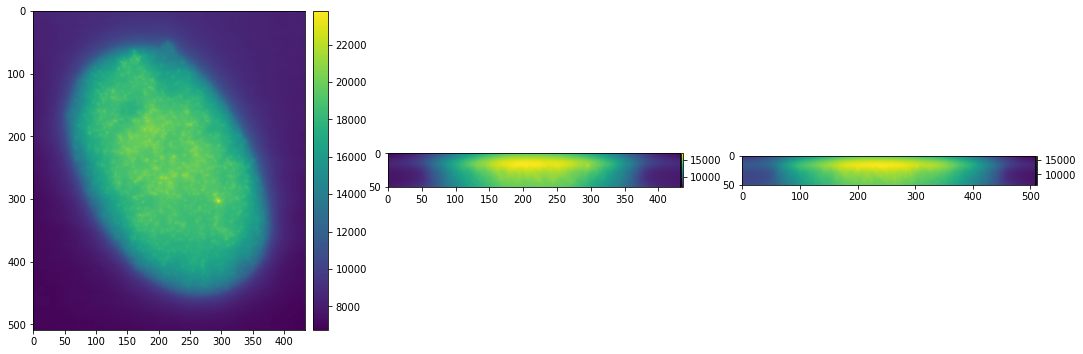

In [8]:
_ = plot_3d_projections(img_3d)

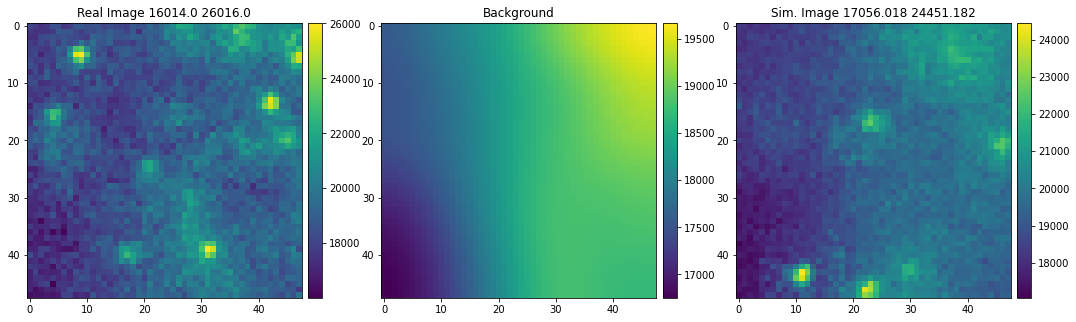

In [9]:
get_simulation_statistics(decode_dl, micro, min_int=cfg.pointprocess.min_int, int_threshold=10000)

In [96]:
!mkdir /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352_2
!mkdir /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352_2/logs

In [97]:
f'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/{cfg.run_name}/logs/ocodsub.log -e /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/{cfg.run_name}/logs/ecodesub.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352_2/logs/ocodsub.log -e /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352_2/logs/ecodesub.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=N2_352_2'

In [125]:
cfg = OmegaConf.load(f'config/experiment/N2_352_2.yaml')
# cfg = OmegaConf.load('config/train.yaml')

In [126]:
model = load_model_state(cfg, 'model_ae.pkl')
psf, noise, micro = load_psf_micro_psf_noise(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_ae.pkl'))

<All keys matched successfully>

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

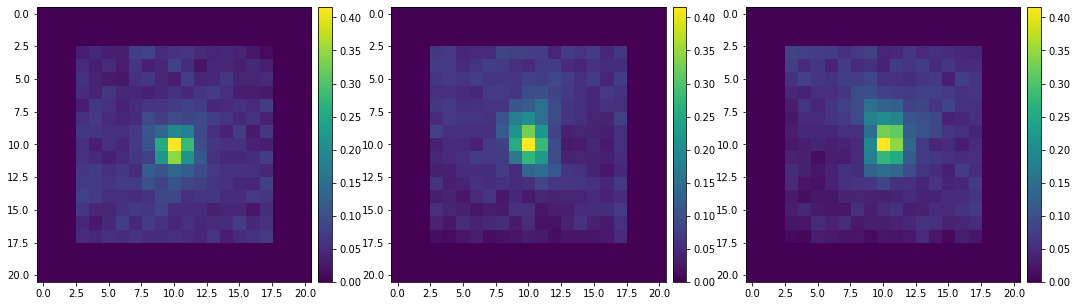

In [127]:
plot_3d_projections(psf_sl.psf_volume[0],'max')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

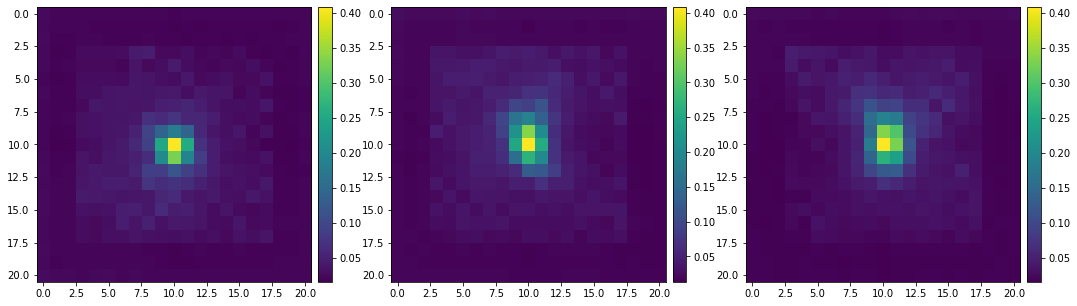

In [128]:
plot_3d_projections(psf.psf_volume[0],'max')

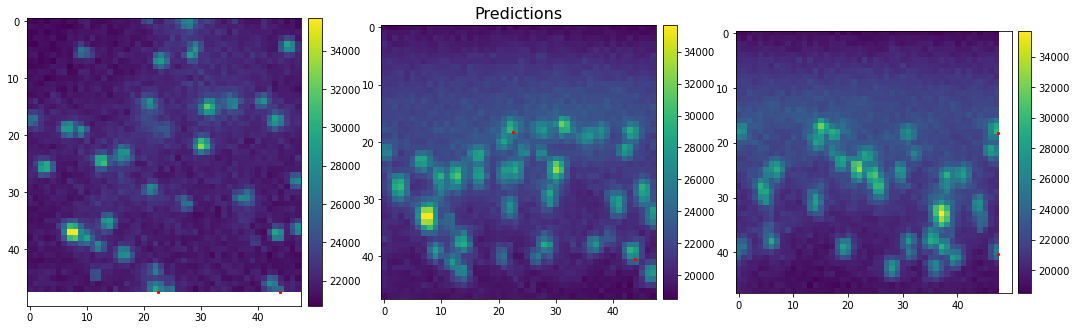

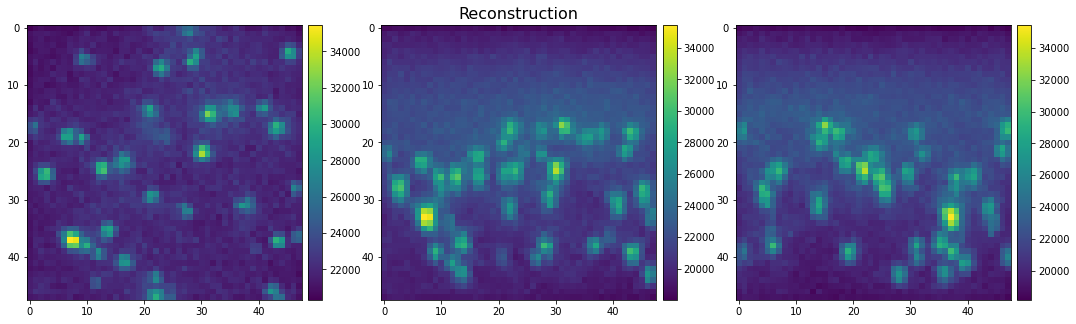

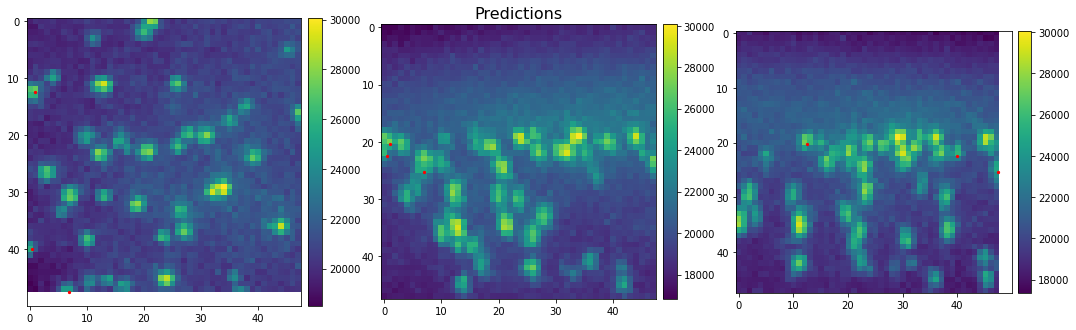

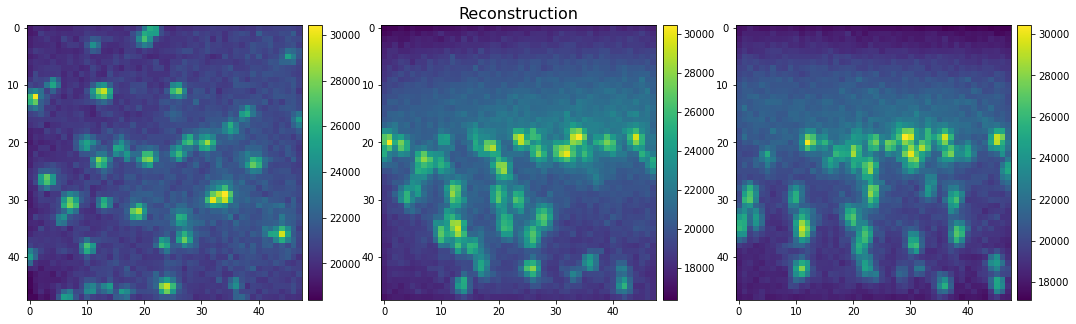

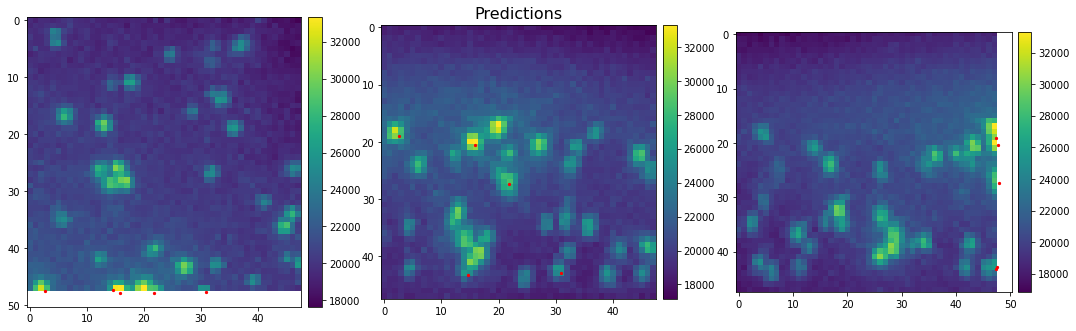

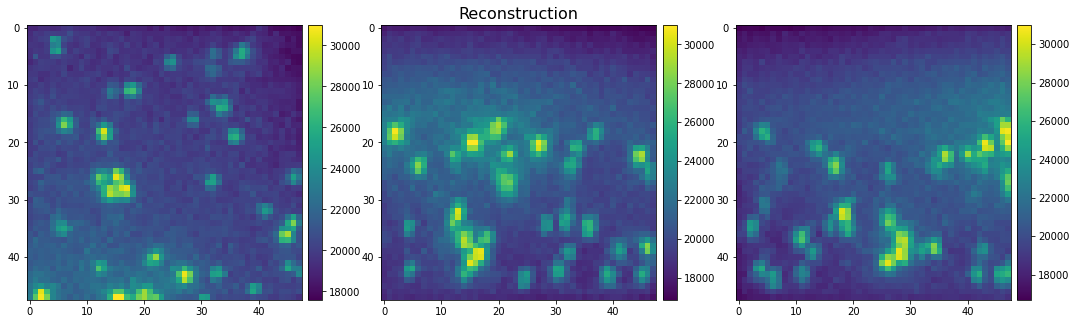

In [130]:
eval_random_crop(decode_dl, model, micro, projection='max', threshold=0.1, samples=3)

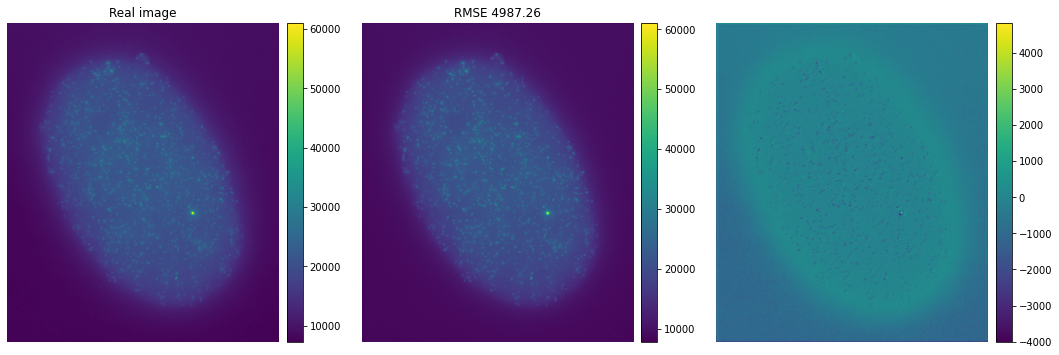

In [145]:
with torch.no_grad():
#     res_gt = model(img_3d[None,None].cuda())
#     locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae = model_output_to_micro_input(res_gt, threshold=0.1)
#     ae_img = micro(locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae)
    pred_gt_df = model_output_to_df(res_gt, 0.1, px_size=[100,100,100])
    free_mem()

    gt_fig = gt_plot(img_3d[None], pred_gt_df, None, [100,100,100], ae_img[0]+res_gt['background'][0])
    plt.show()

In [150]:
res_gt['background'].shape

torch.Size([1, 1, 51, 509, 433])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

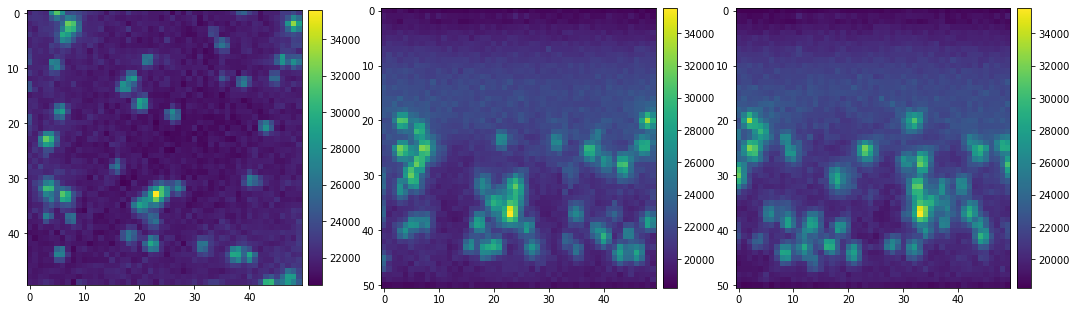

In [155]:
plot_3d_projections(res_gt['background'][0,0,:,200:250,200:250],'max')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

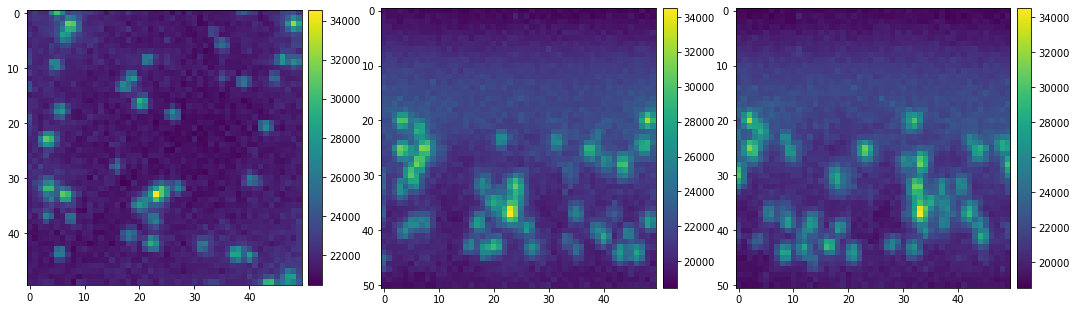

In [156]:
plot_3d_projections(img_3d[:,200:250,200:250],'max')